In [ ]:
# for getting chemcial properties
!pip install rdkit
!pip install git+https://github.com/lmmentel/mendeleev.git@v0.11.0

# torch_geometric lib
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lmmentel/mendeleev.git (to revision v0.11.0) to /tmp/pip-req-build-z93vkyfi
  Running command git clone -q https://github.com/lmmentel/mendeleev.git /tmp/pip-req-build-z93vkyfi
  Running command git checkout -q 9a77d402b82e34a7fdce204509314d8989ceefff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 865 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.1 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.11.0-py3-none-any.whl size=296444 sha256=62206fdd0b941ac6a8918aa4dc6e3d656c0edb7c0f8b422dd49b98a216ee7e1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mr_0st2w/wheel

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 14.7 MB/s 
     |████████████████████████████████| 3.5 MB 16.2 MB/s 
     |████████████████████████████████| 280 kB 4.1 MB/s 


In [ ]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric as geo
import torch_geometric.utils 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# 1 data load

models : GCN, GCN+a, GCN+g, GCN+a+g, GGNN

property : logP, TPSA, QED, SAS (ZINC dataset) and pve (CEP dataset)



> The node features correspond to atom
descriptors including atom type, number of attached hydrogens,
number of valencies, and aromaticity indicator. We represent all
the descriptors with an one-hot encoded vector.



## 1-1 generating feature matrix via the paper way

In [ ]:
import rdkit
from rdkit import Chem 
from rdkit.Chem.QED import qed
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Contrib.SA_Score.sascorer import calculateScore


atomSymbolz = ['Ag', 'Al', 'As', 'Au', 'B', 'Br', 'C', 'Ca', 'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ge', 'H', 'Hg', 'I', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ni', 'O', 'P', 'Pb', 'Pd', 'Pt', 'S', 'Sb', 'Se', 'Si', 'Sn', 'Ti', 'Tl', 'V', 'Zn']


def make_onehot_features(atom):
  ret = []
  ret += list(map(lambda r: r == atom.GetSymbol(), atomSymbolz))
  ret += list(map(lambda r: r == atom.GetDegree(), (0,1,2,3,4,5)))
  ret += list(map(lambda r: r == atom.GetImplicitValence(), (0,1,2,3,4,5)))
  ret += [1 if atom.GetIsAromatic() else 0]

  return np.array(ret) # (atom X 53)

def get_targetProperties(mol):
  l       = torch.tensor(MolLogP(mol), dtype=torch.float).view(1,1)
  t       = torch.tensor(CalcTPSA(mol), dtype=torch.float).view(1,1)
  q       = torch.tensor(qed(mol), dtype=torch.float).view(1,1)
  s       = torch.tensor(calculateScore(mol) , dtype=torch.float).view(1,1)

  return l, t, q, s

# for smiles in tqdm_notebook(SMILES):

def molToData(mol):
  max_atoms = 55
  
  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !! 
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X  
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 53))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    onehot_f = make_onehot_features(atom)
    temp_atomic_f.append(onehot_f)
    atomic_f.append(onehot_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, bonds, padded_atomic_f, padded_adj
  
def load_ZINCdataset1(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list

def load_CEPdataset1(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list


## 1-2 variation of the features

In [ ]:
def get_atomicFeature_table():
  from mendeleev.fetch import fetch_table
  ptable = fetch_table('elements')
  ptable = ptable.select_dtypes(include=np.number)
  
  feature_labels = ['atomic_number','atomic_weight', 'atomic_radius', 'atomic_volume', 'dipole_polarizability', 
                   'vdw_radius', 'en_pauling','boiling_point', 'electron_affinity', 
                   'en_allen', 'en_ghosh']


  ret = ptable[feature_labels].to_numpy(copy=True)
  del ptable

  return ret

def get_molecluarProperty(mol):
  from rdkit.Chem import Descriptors 

  MolWt                     = rdkit.Chem.Descriptors.MolWt(mol)
  HeavyAtomMolWt            = rdkit.Chem.Descriptors.HeavyAtomMolWt(mol)
  NumValenceElectrons       = rdkit.Chem.Descriptors.NumValenceElectrons(mol)
  FractionCSP3              = rdkit.Chem.Lipinski.FractionCSP3(mol)
  HeavyAtomCount            = rdkit.Chem.Lipinski.HeavyAtomCount(mol)
  NHOHCount                 = rdkit.Chem.Lipinski.NHOHCount(mol)
  NOCount                   = rdkit.Chem.Lipinski.NOCount(mol)
  NumAliphaticCarbocycles   = rdkit.Chem.Lipinski.NumAliphaticCarbocycles(mol)
  NumAliphaticHeterocycles  = rdkit.Chem.Lipinski.NumAliphaticHeterocycles(mol)
  NumAliphaticRings         = rdkit.Chem.Lipinski.NumAliphaticRings(mol)
  NumAromaticCarbocycles    = rdkit.Chem.Lipinski.NumAromaticCarbocycles(mol)
  NumAromaticHeterocycles   = rdkit.Chem.Lipinski.NumAromaticHeterocycles(mol)
  NumAromaticRings          = rdkit.Chem.Lipinski.NumAromaticRings(mol)
  NumHAcceptors             = rdkit.Chem.Lipinski.NumHAcceptors(mol)
  NumHDonors                = rdkit.Chem.Lipinski.NumHDonors(mol)
  NumHeteroatoms            = rdkit.Chem.Lipinski.NumHeteroatoms(mol)
  NumRotatableBonds         = rdkit.Chem.Lipinski.NumRotatableBonds(mol)
  RingCount                 = rdkit.Chem.Lipinski.RingCount(mol)
  MolMR                     = rdkit.Chem.Crippen.MolMR(mol)
  
  x = np.array([MolWt, HeavyAtomMolWt, NumValenceElectrons, FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles, NumAliphaticHeterocycles, NumAliphaticRings, NumAromaticCarbocycles, NumAromaticHeterocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, NumRotatableBonds, RingCount, MolMR])
  
  return x

def dataFromMol(mol):
  max_atoms = 55 

  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !! 
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X  
  f_table = get_atomicFeature_table()
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 15))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    value_f = np.concatenate([f_table[atom.GetAtomicNum()-1, :],
                                    [atom.GetTotalNumHs(),
                                    atom.GetDegree(),
                                    atom.GetImplicitValence(),
                                    atom.GetIsAromatic() * 1]])
    
    temp_atomic_f.append(value_f)
    atomic_f.append(value_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  mol_f = get_molecluarProperty(mol)
  
  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  mol_f    = torch.tensor(mol_f, dtype=torch.float).view(1,-1)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, mol_f, bonds, padded_atomic_f, padded_adj

  
def normalize_feature(data):
  def standarize(src_data):
    means = src_data.mean(dim=0, keepdim=True)
    stds  = src_data.std(dim=0, keepdim=True)
    
    return means, stds

  atomic_f = []
  padded_atomic_f = []
  mol_f = []

  for one in data:
    atomic_f.append(one.x)
    mol_f.append(one.mol_f)
    padded_atomic_f.append(one.shaped_x)

  atomic_f = torch.cat(atomic_f, dim=0)
  mol_f    = torch.cat(mol_f, dim=0)
  padded_atomic_f = torch.cat(padded_atomic_f, dim=0)

  a_means, a_stds = standarize(atomic_f)
  m_means, m_stds = standarize(mol_f)


  for idx, one in enumerate(data):
    one.x = (one.x - a_means) / a_stds
    one.mol_f  = (one.mol_f - m_means) / m_stds
    one.shaped_x = (one.shaped_x - a_means) / a_stds

  return data

def load_ZINCdataset2(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  ## scale is matter
  data_list[:, 1] = normalize_feature(data_list[:, 1])
  
  return data_list

def load_CEPdataset2(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  data_list[:, 1] = normalize_feature(data_list[:, 1])

  return data_list


# 2 model implementation

## 2-1 GatedSkipConnection (GATE) & SkipConnection

In [ ]:
class GatedSkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GatedSkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(self.input_dim, self.output_dim, bias=False)
    self.U1 = nn.Linear(self.output_dim, self.output_dim)
    self.U2 = nn.Linear(self.output_dim, self.output_dim)

    self.sigmoid = nn.Sigmoid()

    
  def get_gateCoef(self, f_x, id_x):
    h1 = self.U1(f_x)
    h2 = self.U2(id_x)

    output = self.sigmoid(h1 + h2)

    return output

  def forward(self, f_x, id_x):

    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x)

    z = self.get_gateCoef(f_x, id_x)
    output = z * f_x + (1.0 - z) * id_x
    
    return output

class SkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, f_x, id_x):
    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x) 
    
    output = f_x + id_x

    return output

## 2-2 Graph Convolutional Networks

**1 Attention and gate-augmented graph convoutional networks**
- Graph Convolutional Networks (GCN) with skip connection
- Graph Convolutional Networks (GCN) with gated skip connection
- Graph Attention Networks (GAT) with skip connection
- Graph Attention Networks (GAT) with gated skip connection 

**2 Graph Isomorphic Networks**
- Graph Isomorphic Networks (GIN) 
- Graph Convolution Netowkrs (GCN)
- Graph SAmple and aggreGatE (SAGE); mean aggregator version

**3 Modified SAGE layer**



---



### 1) Attention and Gate-augmented Graph Convutional Networks

1. GCNwithSkip
2. GCNwithGATE
3. GATwithSkip
4. GATwithGATE

In [ ]:
class GCNlayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GCNlayer, self).__init__()

    self.linear = nn.Linear(input_dim, output_dim)
    # self.norm   = nn.BatchNorm1d(55)

  def forward(self, x, adj):
    h = self.linear(x)
    output = torch.matmul(adj, h)
    # h = self.norm(h)
    
    return output

In [ ]:
class GINlayer(nn.Module):
  def __init__(self, mlp, input_dim, output_dim, eps=0):
    super(GCNlayer, self).__init__()

    self.mlp = mlp
    if eps:
      self.eps = nn.Parameter(torch.Tensor((eps)))
    else:
      self.eps = None
    

  def forward(self, x, adj):

    if self.eps is not None:
      # A + (1+eps) * I
      adj = adj - torch.eye(adj.shape[0], dtype=torch.float)
      eye = torch.eye(adj.shape[0], dtype=torch.float)
      adj = adj + (1 + self.eps) * eye
      
    h = torch.matmul(adj, x)
    output = self.mlp(h)
    
    return output

In [ ]:
class GCNwithSkip(nn.Module):
  def __init__(self, args):
    super(GCNwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output
  

In [ ]:
class GCNwithGate(nn.Module):
  def __init__(self, args):
    super(GCNwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])
    
    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output
  

In [ ]:
# multihead attention
class GATlayer(nn.Module):
  def __init__(self, input_dim, output_dim, head_num):
    super(GATlayer, self).__init__()
    self.W1 = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.att_weight = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.act = nn.ReLU()
    self.head_num = head_num

  def attention(self, x, adj):
    attn = []
    for layer in self.att_weight:
      h = layer(x)
      ch = torch.matmul(h.transpose(1,2), adj)
      hch = torch.matmul(h, ch)
      attn.append(torch.tanh(hch))

    return attn
  
  def forward(self, x, adj):
    attns = self.attention(x, adj)
    outputs = []      
    for i in range (len(attns)):
      h = self.W1[i](x)
      outputs.append(torch.matmul(attns[i],h))
    outputs = torch.stack(outputs)
    output = torch.sum(outputs, dim=0, keepdim=False)
    output /= self.head_num
    output = self.act(output)

    return output 

In [ ]:
class GATwithSkip(nn.Module):
  def __init__(self, args):
    super(GATwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output

In [ ]:
class GATwithGate(nn.Module):
  def __init__(self, args):
    super(GATwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()
    
  def forward(self, G):
    
    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])
    
    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1) 

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3) 

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)
    
    output = self.mlp(readout)

    return output

### 2) Graph Isomorphic Netwokrs
1. GIN
2. GCN
3. SAGE

In [ ]:
class MLPcell(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLPcell, self).__init__()

    self.mlp = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

  def forward(self, x):

    output = self.mlp(x)

    return output

In [ ]:
class GIN(nn.Module):
  def __init__(self, args):
      super(GIN, self).__init__()

      self.mol_dim = args.mol_dim

      self.conv1 = geo.nn.GINConv(nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
      self.conv2 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv3 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv4 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv5 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))

      self.norm1 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm2 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm3 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm4 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm5 = geo.nn.BatchNorm(args.hidden_dim)

      self.dropout = nn.Dropout(args.dropout)

      self.mlp = nn.Sequential(
          nn.Linear(args.hidden_dim*5 +args.input_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

      self.act = nn.ReLU()

  def forward(self, G):
    edge = G.edge_index


    h1 = self.conv1(G.x,  edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1, edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)

    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)


    h0 = geo.nn.global_add_pool(G.x, G.batch)
    h1 = geo.nn.global_add_pool(h1, G.batch)
    h2 = geo.nn.global_add_pool(h2, G.batch)
    h3 = geo.nn.global_add_pool(h3, G.batch)
    h4 = geo.nn.global_add_pool(h4, G.batch)
    h5 = geo.nn.global_add_pool(h5, G.batch)

    h = torch.cat( (h0, h1, h2, h3, h4, h5), dim=1 )
    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)
    
    output = self.mlp(h)

    return output

In [ ]:
class GCN(nn.Module):
  def __init__(self, args):
    super(GCN, self).__init__()

    self.mol_dim = args.mol_dim
    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.GCNConv(args.input_dim, args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)    

    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    # the origin version used softmax fucntion for 'node classification' 
    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h2)
    h3 = self.skip3(h3, id3)

    h = geo.nn.global_add_pool(h3, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

In [ ]:
class SAGE(nn.Module):
  def __init__(self, args):
    super(SAGE, self).__init__()

    self.mol_dim = args.mol_dim
    
    

    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.SAGEConv(args.input_dim, args.hidden_dim, aggr=args.aggr)
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)


    # Chen and Zhu achieve superior performance by optimizing the GraphSAGE hyperparameters with layer normalization

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

### 3) Modified SAGE layer

In [ ]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTM
from torch_sparse import SparseTensor, matmul

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size

class modified_SAGEConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        self_nn=None,
        neighbor_nn=None,
        aggr: Optional[Union[str, List[str], Aggregation]] = "add",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == 'lstm':
            kwargs.setdefault('aggr_kwargs', {})
            kwargs['aggr_kwargs'].setdefault('in_channels', in_channels[0])
            kwargs['aggr_kwargs'].setdefault('out_channels', in_channels[0])

        super().__init__(aggr, **kwargs)

        if self.project:
            self.lin = Linear(in_channels[0], in_channels[0], bias=True)

        if self.aggr is None:
            self.fuse = False  # No "fused" message_and_aggregate.
            self.lstm = LSTM(in_channels[0], in_channels[0], batch_first=True)

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(
                in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        if neighbor_nn is None:
          self.mlp_l = Linear(aggr_out_channels, out_channels, bias=bias)
        else:
          self.mlp_l = neighbor_nn
        if self.root_weight:
          if self_nn is None:
            self.mlp_r = Linear(in_channels[1], out_channels, bias=False)
          else:
            self.mlp_r = self_nn
        

        self.reset_parameters()

    def reset_parameters(self):
        if self.project:
            self.lin.reset_parameters()
        self.aggr_module.reset_parameters()
        # self.mlp_l.reset_parameters()
        # if self.root_weight:
        #     self.mlp_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.mlp_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.mlp_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')


In [ ]:
class modified_SAGE(nn.Module):
  def __init__(self, args):
    super(modified_SAGE, self).__init__()

    self.mol_dim = args.mol_dim

    self.hidden_dim = args.hidden_dim

    self.conv1 = modified_SAGEConv(args.input_dim, args.hidden_dim,
                                   self_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim),
                                   neighbor_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)
    
    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ELU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

# 3 Training

## 3-1 train, test and runner functions

In [ ]:
def train(model, data_loader, optimizer, criterion, DEVICE):
    model.train()
    train_loss = 0

    for batch in data_loader:

        pred = model(batch.to(DEVICE))
        loss = criterion(pred, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def test(model, data_loader,DEVICE):
    model.eval()
    list_preds = list()
    
    with torch.no_grad():
        for batch in data_loader:
            preds = model(batch.to(DEVICE))
            list_preds.append(preds)

    return torch.cat(list_preds, dim=0).cpu().numpy()

In [ ]:
def set_targetY(dataset, target=''):
  # default Y == LogP
  if target == 'LogP':
    for one in dataset:
      one.y = one.LogP

  if target == 'TPSA':
    for one in dataset:
      one.y = one.TPSA

  # if target == 'QED':
  #   for one in dataset:
  #     one.y = one.QED

  if target == 'SAS':
    for one in dataset:
      one.y = one.SAS
  
  return dataset



def run_training(model, args, ZINC_data, CEP_data, target_prop=""):

  from datetime import datetime, timezone, timedelta
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import r2_score

  print(f'Experiment start, {datetime.now(timezone(timedelta(hours=9)))}')

  test_results = []
  loss_log = [] 

  GNN     = model(args).to(args.DEVICE)
  print(GNN)
  del GNN
  # logP prediction y = logP
  for target in ['LogP', 'TPSA', 'SAS', 'CEP']:

    stage_loss = []

    if target_prop: # if you use target_prop, the function works for the target_prop
      if target_prop in ['LogP', 'TPSA', 'SAS', 'CEP']:
        target = target_prop
        
        

    if target == 'CEP':
      args.epochs = 200
      args.weight_decay = 0.0
      whole_train_set, test_set =train_test_split(CEP_data, test_size=0.1, random_state=42)
    else:
      args.epochs = 100
      args.weight_decay = 0.0
      ZINC_data[:, 1] = set_targetY(ZINC_data[:, 1], target)
      whole_train_set, test_set =train_test_split(ZINC_data, test_size=0.1, random_state=42)

    train_set, valid_set = train_test_split(whole_train_set, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_set[:,1], batch_size=args.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set[:,1], batch_size=args.batch_size, shuffle=False)
    test_loader  = DataLoader(test_set[:,1], batch_size=args.batch_size, shuffle=False)
    whole_train_loader = DataLoader(whole_train_set[:,1], batch_size=args.batch_size, shuffle=True)

    gt = np.array([data[1].y.item() for data in valid_set]).reshape(-1,1)
  
    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()

    
    print(target)
    for idx in range(args.epochs):
      train_loss = train(GNN, train_loader, optimizer, criterion, args.DEVICE)
      stage_loss.append(train_loss)
      
      if (idx + 1) % 10 == 0 :
        pred = test(GNN, valid_loader, args.DEVICE)

        
        residual = np.abs(gt-pred)
        MAE = residual.mean()
        MAE_std = residual.std()

        R2 = r2_score(gt, pred)

        print(f'{idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
    
    del GNN, optimizer, criterion, gt

    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()

    gt = np.array([data[1].y.item() for data in test_set]).reshape(-1,1)

    for idx in range(args.epochs):
      train(GNN, whole_train_loader, optimizer, criterion, args.DEVICE)
    
    pred = test(GNN, test_loader, args.DEVICE)
    
    
    residual = np.abs(gt-pred)
    MAE = residual.mean()
    MAE_std = residual.std()

    R2 = r2_score(gt, pred)
    print('='*80)
    print(f'\t test score {idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
    test_results.append( (MAE, MAE_std, R2))
    print('='*80)

    loss_log.append(stage_loss)

    if target_prop:
      print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
      return test_results, loss_log
  
  print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
  return test_results #, loss_log # (5 x 3)
      

# 4 Experiments

## 4.1 Experiment 1; one-hot feature training
**DataSet**: one-hot encodded features ( *dim = 53* )

**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
from easydict import EasyDict as edict

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

args = edict()

args.input_dim  = 53 # 53 is for onehot-featuring 
args.hidden_dim = 32
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'mean'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
# args.weight_decay = 0.95 # logP, TPSA, SAS
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data =load_ZINCdataset1('/content/ZINC_smiles.txt')
CEP_data  =load_CEPdataset1('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 329464


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip = run_training(GCNwithSkip, args, ZINC_data, CEP_data)
results_GCNwithSkip

GCNwithSkip(
  (conv1): GCNlayer(
    (linear): Linear(in_features=53, out_features=32, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (skip1): SkipConnection(
    (proj): Linear(in_features=53, out_features=32, bias=False)
  )
  (skip2): SkipConnection()
  (skip3): SkipConnection()
  (readout): Linear(in_features=32, out_features=512, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=0.662 ;;0.662 + 0.593, R2=0.598
 20 epoch: MAE + std=0.624 ;;0.624 + 0.539, R2=0.654
 30 epoch: MAE + std=0.698 ;;0.698 + 0.509, R2=0.620
 40 epoch: MAE + std=0.650 ;;0.650 + 0.508, R2=0.654
 50 epoch: MAE + std=0.61

([(0.6166293261260726, 0.5012465342240553, 0.6798086941231027),
  (3.123841670513153, 1.9229357566476681, 0.9771581300121474),
  (0.16530784676969051, 0.10546264439551371, -0.4826965028519494),
  (0.4566685426235199, 0.38176111535913365, 0.16288920496843073),
  (1.416832413024269, 1.3559255965989536, 0.3640986319927292)],
 [[17.31860802322626,
   1.1690065115690231,
   1.005480379694038,
   0.9103280645277765,
   0.8247893311911159,
   0.7763992597659429,
   0.7528067032496134,
   0.7355807647109032,
   0.7175057700110806,
   0.7489497972031435,
   0.7387724804381529,
   0.7205233201384544,
   0.716692540794611,
   0.7161526460614469,
   0.7061030947499805,
   0.6955770129958788,
   0.7098285340600543,
   0.741795582903756,
   0.7237842612796359,
   0.7277841162350442,
   0.7207204931312137,
   0.7419876323805915,
   0.7358349015315374,
   0.7177705421215959,
   0.7395605217251513,
   0.7182012908160686,
   0.7458477608031697,
   0.7277370790640513,
   0.7165000985066096,
   0.71330264

In [ ]:
results_GCNwithGate = run_training(GCNwithGate, args, ZINC_data, CEP_data)
results_GCNwithGate

GCNwithGate(
  (conv1): GCNlayer(
    (linear): Linear(in_features=53, out_features=32, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (skip1): GatedSkipConnection(
    (proj): Linear(in_features=53, out_features=32, bias=False)
    (U1): Linear(in_features=32, out_features=32, bias=True)
    (U2): Linear(in_features=32, out_features=32, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip2): GatedSkipConnection(
    (U1): Linear(in_features=32, out_features=32, bias=True)
    (U2): Linear(in_features=32, out_features=32, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip3): GatedSkipConnection(
    (U1): Linear(in_features=32, out_features=32, bias=True)
    (U2): Linear(in_features=32, out_features=32, bias=True)
    (sigmoid): Sigmoid()
  )
  (readout): Linear(in_features=32, out_features=512, bias=True)
  (mlp): Sequential(
    (0): Linear(in

([(0.9207081522531807, 0.6513143019226706, 0.3550771719023902),
  (1.8465101370811463, 1.5876346498614624, 0.9899334283490606),
  (0.1676498808115721, 0.10732446532749587, -0.5280449884158271),
  (0.4910830628871918, 0.46943875621386655, -0.09051539585772717),
  (1.5879969605868682, 1.4079089362485044, 0.2553038686005694)],
 [[2.237240372432603,
   1.5006215671698253,
   1.4681750097208552,
   1.4264792485369577,
   1.4069573630889256,
   1.3857911535435252,
   1.405096985399723,
   1.3716204141577084,
   1.334698985848162,
   1.3332475970188777,
   1.3419356395800908,
   1.387389714519183,
   1.318633436328835,
   1.3274532854557037,
   1.3031623603569136,
   1.30497191598018,
   1.3038074150681496,
   1.2989972705642383,
   1.2948268403609593,
   1.296279392308659,
   1.293266420563062,
   1.2932323921057913,
   1.279768593609333,
   1.3039987666739359,
   1.3536867871880531,
   1.285910564992163,
   1.2854217696521018,
   1.2868945805562868,
   1.2789806839492586,
   1.3037592023611

In [ ]:
results_GATwithSkip = run_training(GATwithSkip, args, ZINC_data, CEP_data)
results_GATwithSkip

GATwithSkip(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=53, out_features=32, bias=True)
      (1): Linear(in_features=53, out_features=32, bias=True)
      (2): Linear(in_features=53, out_features=32, bias=True)
      (3): Linear(in_features=53, out_features=32, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=53, out_features=32, bias=True)
      (1): Linear(in_features=53, out_features=32, bias=True)
      (2): Linear(in_features=53, out_features=32, bias=True)
      (3): Linear(in_features=53, out_features=32, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=T

([(0.5024369121082127, 0.4731668722585642, 0.7584774081333215),
  (1.302907163143158, 1.2208238824025717, 0.9945883614881497),
  (0.10781273071467877, 0.08742090106475159, 0.2570524768532372),
  (0.4033867183923721, 0.39476022216290974, 0.2473149338182543),
  (1.3524516127770767, 1.3011506240314594, 0.41764171750160395)],
 [[16213.266076631844,
   1.1867934746874704,
   1.0797949466440413,
   1.006267312500212,
   1.0933414159549608,
   0.9306618190473981,
   0.8990217058195008,
   0.9527781311836507,
   0.9343038706315888,
   0.90479659785827,
   0.8065901647011439,
   0.8176785020364655,
   0.7835763523148166,
   0.7470637394322289,
   0.9082720258997546,
   0.7632135550181071,
   0.7592887025740411,
   0.7146625001397398,
   0.7268581121332116,
   0.7530289101931784,
   1.1438433544503317,
   0.9487941770089997,
   0.7537209437125258,
   0.7135967289408048,
   0.7044521243207984,
   0.7069924424091975,
   0.7356957064734565,
   1.0851550143626,
   0.9865544976459609,
   0.7338351512

In [ ]:
results_GATwithGate = run_training(GATwithGate, args, ZINC_data, CEP_data)
results_GATwithGate

GATwithGate(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=53, out_features=32, bias=True)
      (1): Linear(in_features=53, out_features=32, bias=True)
      (2): Linear(in_features=53, out_features=32, bias=True)
      (3): Linear(in_features=53, out_features=32, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=53, out_features=32, bias=True)
      (1): Linear(in_features=53, out_features=32, bias=True)
      (2): Linear(in_features=53, out_features=32, bias=True)
      (3): Linear(in_features=53, out_features=32, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=T

([(0.6622493265457451, 0.5415031596108765, 0.6289415084849104),
  (2.198291628360748, 1.6069998796173266, 0.9874130418031823),
  (0.16103345750272274, 0.10132433971367728, -0.39590524488039636),
  (0.5321858634948731, 0.3973172310672965, -0.042190133829330234),
  (1.3542295647924767, 1.2845905687175299, 0.42392602661844103)],
 [[206.98100247730812,
   1.3379122813542683,
   1.1711037812961473,
   1.109196066028542,
   0.9579464296499888,
   0.9049541258977519,
   0.8303270778722234,
   0.8841370584236251,
   0.8317997190687392,
   0.7772692400548193,
   0.8258500256472163,
   0.8229181836876605,
   0.8274757030109564,
   0.7883533222807778,
   0.7595758156643974,
   0.7634641693698035,
   0.7746561600102319,
   0.798247805900044,
   0.7588904259933366,
   0.7701104548242357,
   0.7701904397043917,
   0.7637881168888675,
   0.7389581091701984,
   0.7713097234567007,
   0.7931735329329967,
   0.7616476027501954,
   0.7484916489985254,
   0.7480196315381262,
   0.7446127840214305,
   0.73

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data, CEP_data)
results_GIN

GIN(
  (conv1): modified_SAGEConv(53, 32, aggr=add)
  (conv2): modified_SAGEConv(32, 32, aggr=add)
  (conv3): modified_SAGEConv(32, 32, aggr=add)
  (conv4): modified_SAGEConv(32, 32, aggr=add)
  (conv5): modified_SAGEConv(32, 32, aggr=add)
  (norm1): BatchNorm(32)
  (norm2): BatchNorm(32)
  (norm3): BatchNorm(32)
  (norm4): BatchNorm(32)
  (norm5): BatchNorm(32)
  (dropout): Dropout(p=0.5, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=213, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=0.370 ;;0.370 + 0.328, R2=0.876
 20 epoch: MAE + std=0.460 ;;0.460 + 0.385, R2=0.817
 30 epoch: MAE + std=0.515 ;;0.515 + 0.440, R2=0.766
 40 epoch: MAE + std=0.451 ;;0.451 + 0.330, R2=0.841
 50 epoch: MAE + std=0.380 ;;0.380 + 0.340, R2=0.868
 60 epoch: MAE + std=0.399 ;;0.399 + 0.370, R2=0.849
 70 epoch:

([(1.1634218021677807, 0.5506778388997382, 0.15992279999816172),
  (5.15723035812378, 2.0826692369785103, 0.9474881804237267),
  (0.18931194968521595, 0.11751556412320274, -0.914592853314419),
  (0.786770003080368, 0.43954282256780375, -0.9190773535805157),
  (1.0523149112192913, 1.3149389225466135, 0.5310154389279327)],
 [[2.142816189676523,
   0.2911796211782429,
   0.1912657709585296,
   0.22842155893643698,
   0.18170154146436188,
   0.20476906208528411,
   0.22163967705435222,
   0.22612441413932377,
   0.18594143363750643,
   0.2082228417404824,
   0.19636617538829645,
   0.20870953073932064,
   0.2509658735038506,
   0.2052884976276093,
   0.23385815446575484,
   0.2257997780624363,
   0.21746775238878197,
   0.23312241956591606,
   0.21729779326253468,
   0.22403762406773037,
   0.21690715363042223,
   0.26224129885021186,
   0.2399371980379025,
   0.303086516343885,
   0.2674542414024472,
   0.26257763399432105,
   0.24356872184822956,
   0.2503898289675514,
   0.2482952715622

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data, CEP_data)
results_GCN

LogP:   0%|          | 0/100 [00:00<?, ?it/s]

 10 epoch: MAE + std=0.839 ;;0.839 + 0.651, R2=0.426
 20 epoch: MAE + std=0.873 ;;0.873 + 0.634, R2=0.407
 30 epoch: MAE + std=0.844 ;;0.844 + 0.643, R2=0.427
 40 epoch: MAE + std=0.842 ;;0.842 + 0.645, R2=0.428
 50 epoch: MAE + std=0.838 ;;0.838 + 0.648, R2=0.428
 60 epoch: MAE + std=0.839 ;;0.839 + 0.649, R2=0.428
 70 epoch: MAE + std=0.844 ;;0.844 + 0.646, R2=0.425
 80 epoch: MAE + std=0.832 ;;0.832 + 0.675, R2=0.415
 90 epoch: MAE + std=0.850 ;;0.850 + 0.638, R2=0.425
100 epoch: MAE + std=0.845 ;;0.845 + 0.645, R2=0.426


	 training LogP:   0%|          | 0/100 [00:00<?, ?it/s]

	 test score 100 epoch: MAE + std=0.889 ;;0.889 + 0.632, R2=0.396


TPSA:   0%|          | 0/100 [00:00<?, ?it/s]

 10 epoch: MAE + std=5.233 ;;5.233 + 5.046, R2=0.916
 20 epoch: MAE + std=5.313 ;;5.313 + 4.087, R2=0.928
 30 epoch: MAE + std=4.687 ;;4.687 + 4.574, R2=0.932
 40 epoch: MAE + std=4.405 ;;4.405 + 4.193, R2=0.941
 50 epoch: MAE + std=4.291 ;;4.291 + 4.037, R2=0.945
 60 epoch: MAE + std=4.371 ;;4.371 + 3.824, R2=0.946
 70 epoch: MAE + std=4.187 ;;4.187 + 3.887, R2=0.948
 80 epoch: MAE + std=4.154 ;;4.154 + 3.752, R2=0.950
 90 epoch: MAE + std=4.369 ;;4.369 + 4.267, R2=0.941
100 epoch: MAE + std=4.007 ;;4.007 + 3.864, R2=0.951


	 training TPSA:   0%|          | 0/100 [00:00<?, ?it/s]

	 test score 100 epoch: MAE + std=3.969 ;;3.969 + 3.866, R2=0.948


QED:   0%|          | 0/100 [00:00<?, ?it/s]

 10 epoch: MAE + std=0.179 ;;0.179 + 0.116, R2=-0.761
 20 epoch: MAE + std=0.178 ;;0.178 + 0.117, R2=-0.743
 30 epoch: MAE + std=0.178 ;;0.178 + 0.116, R2=-0.743
 40 epoch: MAE + std=0.178 ;;0.178 + 0.115, R2=-0.734
 50 epoch: MAE + std=0.181 ;;0.181 + 0.114, R2=-0.767
 60 epoch: MAE + std=0.178 ;;0.178 + 0.118, R2=-0.755
 70 epoch: MAE + std=0.179 ;;0.179 + 0.115, R2=-0.744
 80 epoch: MAE + std=0.181 ;;0.181 + 0.113, R2=-0.757
 90 epoch: MAE + std=0.178 ;;0.178 + 0.117, R2=-0.745
100 epoch: MAE + std=0.180 ;;0.180 + 0.114, R2=-0.755


	 training QED:   0%|          | 0/100 [00:00<?, ?it/s]

	 test score 100 epoch: MAE + std=0.184 ;;0.184 + 0.115, R2=-0.811


SAS:   0%|          | 0/100 [00:00<?, ?it/s]

 10 epoch: MAE + std=0.527 ;;0.527 + 0.497, R2=-0.441
 20 epoch: MAE + std=0.532 ;;0.532 + 0.484, R2=-0.422
 30 epoch: MAE + std=0.538 ;;0.538 + 0.537, R2=-0.585
 40 epoch: MAE + std=0.538 ;;0.538 + 0.474, R2=-0.412
 50 epoch: MAE + std=0.530 ;;0.530 + 0.487, R2=-0.421
 60 epoch: MAE + std=0.525 ;;0.525 + 0.505, R2=-0.459
 70 epoch: MAE + std=0.526 ;;0.526 + 0.501, R2=-0.449
 80 epoch: MAE + std=0.526 ;;0.526 + 0.503, R2=-0.454
 90 epoch: MAE + std=0.528 ;;0.528 + 0.514, R2=-0.491
100 epoch: MAE + std=0.535 ;;0.535 + 0.480, R2=-0.418


	 training SAS:   0%|          | 0/100 [00:00<?, ?it/s]

	 test score 100 epoch: MAE + std=0.580 ;;0.580 + 0.522, R2=-0.438


CEP:   0%|          | 0/200 [00:00<?, ?it/s]

 10 epoch: MAE + std=0.529 ;;0.529 + 0.518, R2=-0.507
 20 epoch: MAE + std=0.532 ;;0.532 + 0.487, R2=-0.429
 30 epoch: MAE + std=0.535 ;;0.535 + 0.533, R2=-0.567
 40 epoch: MAE + std=0.526 ;;0.526 + 0.496, R2=-0.438
 50 epoch: MAE + std=0.532 ;;0.532 + 0.526, R2=-0.537
 60 epoch: MAE + std=0.526 ;;0.526 + 0.507, R2=-0.466
 70 epoch: MAE + std=0.527 ;;0.527 + 0.511, R2=-0.481
 80 epoch: MAE + std=0.528 ;;0.528 + 0.507, R2=-0.473
 90 epoch: MAE + std=0.527 ;;0.527 + 0.497, R2=-0.441
100 epoch: MAE + std=0.530 ;;0.530 + 0.488, R2=-0.425
110 epoch: MAE + std=0.548 ;;0.548 + 0.470, R2=-0.434
120 epoch: MAE + std=0.536 ;;0.536 + 0.477, R2=-0.415
130 epoch: MAE + std=0.527 ;;0.527 + 0.492, R2=-0.429
140 epoch: MAE + std=0.532 ;;0.532 + 0.485, R2=-0.424
150 epoch: MAE + std=0.531 ;;0.531 + 0.485, R2=-0.423
160 epoch: MAE + std=0.528 ;;0.528 + 0.493, R2=-0.432
170 epoch: MAE + std=0.526 ;;0.526 + 0.502, R2=-0.451
180 epoch: MAE + std=0.528 ;;0.528 + 0.491, R2=-0.431
190 epoch: MAE + std=0.533 ;

	 training CEP:   0%|          | 0/200 [00:00<?, ?it/s]

	 test score 200 epoch: MAE + std=2.083 ;;2.083 + 1.861, R2=-0.290


In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data, CEP_data)
results_SAGE

# epoch:   0%|          | 0/100 [00:00<?, ?it/s]

 10 epoch: MAE=0.37317, R2=0.854
 20 epoch: MAE=0.46682, R2=0.841
 30 epoch: MAE=0.26363, R2=0.929
 40 epoch: MAE=0.33345, R2=0.902
 50 epoch: MAE=0.26214, R2=0.930
 60 epoch: MAE=0.25825, R2=0.926
 70 epoch: MAE=0.25904, R2=0.928
 80 epoch: MAE=0.29691, R2=0.909
 90 epoch: MAE=0.27640, R2=0.917
100 epoch: MAE=0.26280, R2=0.923


In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data, CEP_data)
results_mSAGE 

## 4.2 Experiment 2; atomic feature training
**DataSet**: atomic feature values *( dim = 15 )*

**Model**;
**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 16 is for atomic f
args.hidden_dim = 256 # 
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data2 =load_ZINCdataset2('/content/ZINC_smiles.txt')
CEP_data2  =load_CEPdataset2('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 500000


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip2 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip2

GCNwithSkip(
  (conv1): GCNlayer(
    (linear): Linear(in_features=15, out_features=256, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (skip1): SkipConnection(
    (proj): Linear(in_features=15, out_features=256, bias=False)
  )
  (skip2): SkipConnection()
  (skip3): SkipConnection()
  (readout): Linear(in_features=256, out_features=512, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=0.647 ;;0.647 + 0.545, R2=0.636
 20 epoch: MAE + std=0.691 ;;0.691 + 0.545, R2=0.606
 30 epoch: MAE + std=0.686 ;;0.686 + 0.540, R2=0.612
 40 epoch: MAE + std=0.666 ;;0.666 + 0.561, R2=0.614
 50 epoch: MAE + s

([(0.5981053461059928, 0.4641244042090574, 0.7093891032968702),
  (1.9359468603134156, 1.856128530376922, 0.987789603672084),
  (0.13677172414958477, 0.08587784794180459, -0.00577150884491151),
  (0.43235601687431335, 0.3400324436535093, 0.2851260796057631),
  (1.281180002993904, 1.296096664098096, 0.450847516012182)],
 [[252.40647370782165,
   1.0496986582875252,
   0.9544421997335222,
   0.8934270168344179,
   1.020674395064513,
   0.9655893387065994,
   0.8149619168705411,
   0.9101377866334386,
   0.8583918656739924,
   1.0051861670282152,
   0.8044565328293376,
   0.9295977672768964,
   0.9492766534288725,
   0.9143331141935455,
   1.113736818648047,
   0.8804428312513564,
   0.9164995807740424,
   1.0184798199269507,
   0.8861027616593573,
   0.9894275880522199,
   0.8649021507137351,
   0.9819531626999378,
   0.8491143799490399,
   0.9410371225741174,
   0.894140029946963,
   0.8958587075273196,
   0.8707398523886999,
   0.8484109110302396,
   0.9076348005069627,
   0.8992547086

In [ ]:
results_GCNwithGate2 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate2

GCNwithGate(
  (conv1): GCNlayer(
    (linear): Linear(in_features=15, out_features=256, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (skip1): GatedSkipConnection(
    (proj): Linear(in_features=15, out_features=256, bias=False)
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip2): GatedSkipConnection(
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip3): GatedSkipConnection(
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (readout): Linear(in_features=256, out_features=512, bias=True)
  (mlp): Sequential(

([(0.7339701287634671, 0.5479043846297087, 0.5746307016731977),
  (1.31890185546875, 1.111809582830533, 0.9949488377883035),
  (0.1672504208534956, 0.107007517840193, -0.5202664729963906),
  (0.48806800866127015, 0.4457698639962661, -0.03235705409776268),
  (1.1833984898282215, 1.3051403398083796, 0.48680395093887807)],
 [[8.507848164273632,
   0.904507677588198,
   1.0154553593860731,
   0.9724342334601614,
   0.9549174217714204,
   0.9459511662522951,
   0.9255920698245367,
   0.958108563390043,
   0.97706355402867,
   0.9430235591199663,
   0.988035476870007,
   0.9896821710798476,
   0.9853527438309457,
   0.9739166109098328,
   0.9996413480904367,
   0.9675041370921664,
   0.9731104059351815,
   0.976517465379503,
   0.9693705373340182,
   0.9292493205931451,
   0.9645501068896718,
   0.9835902808441056,
   0.9511918789810605,
   0.9286086393727196,
   1.0102778209580316,
   1.0307922752367125,
   0.9373652123742633,
   0.9293287040458785,
   0.9508296412726244,
   0.9279053368502

In [ ]:
results_GATwithSkip2 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip2

GATwithSkip(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=256, out_fe

([(0.4693479094281793, 0.39950820312875857, 0.8073749343201799),
  (3.0080156474113466, 2.513380666224637, 0.973917283444562),
  (0.10781953425705433, 0.08813696676321069, 0.2521481579281054),
  (0.3856357449293137, 0.3253970903315206, 0.39843552992254183),
  (1.0348401510948315, 1.1807055918446463, 0.5924356742590393)],
 [[127216.44501766894,
   18.570606377389694,
   51.81984036167463,
   3.5389965259366565,
   2.736808800035053,
   3.5406530516015158,
   5.556644259227647,
   26.495455048150486,
   2.9280980394946203,
   2.5074105312426886,
   2.4553384077217846,
   2.042881759504477,
   1.8723026596837573,
   1.7619370602899127,
   2.0964119964175754,
   5.908494947685136,
   16.445032959183056,
   1.9145914415518444,
   2.0410533423225083,
   1.3325561905900638,
   1.8064978445569675,
   1.4881085223621793,
   1.861235834658146,
   1.4126750735772982,
   1.5539569614662065,
   1.1412351098325517,
   2.3470358277360597,
   1.5246357429358695,
   1.7744249229629834,
   13.0557315995

In [ ]:
results_GATwithGate2 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate2

GATwithGate(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=256, out_fe

([(0.4891029637083411, 0.3972136199377221, 0.7987012984821922),
  (1.3827787036895751, 1.1308426234804383, 0.9945834319830744),
  (0.14241022281348706, 0.0902515996488825, -0.09618210820357742),
  (0.42182302069664, 0.36087280874326255, 0.271870640515142),
  (1.0204894710769876, 1.1730715102335416, 0.6002835738037162)],
 [[3277.500988658104,
   1.0520527793301477,
   0.8349546852211157,
   0.7056003904177083,
   0.6728797430793444,
   0.5944332078927093,
   0.6658174846735265,
   0.6076318803760741,
   0.6230341324375736,
   0.5830842177901003,
   0.638107992708683,
   0.5779408108856943,
   0.5905373357236385,
   0.5576339736580849,
   0.5129858023590512,
   0.8811195240252547,
   0.61528997330202,
   0.47439565426773495,
   0.4282236194445027,
   0.4558057122760349,
   0.45463545951578355,
   0.47056009206506944,
   0.4346813340153959,
   0.4154193891833226,
   0.4160194732248783,
   0.41711544597314465,
   0.4494028010716041,
   0.5459403408070406,
   0.42668475376235115,
   0.42896

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

GIN(
  (conv1): modified_SAGEConv(15, 256, aggr=add)
  (conv2): modified_SAGEConv(256, 256, aggr=add)
  (conv3): modified_SAGEConv(256, 256, aggr=add)
  (conv4): modified_SAGEConv(256, 256, aggr=add)
  (conv5): modified_SAGEConv(256, 256, aggr=add)
  (norm1): BatchNorm(256)
  (norm2): BatchNorm(256)
  (norm3): BatchNorm(256)
  (norm4): BatchNorm(256)
  (norm5): BatchNorm(256)
  (dropout): Dropout(p=0.5, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=1295, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=0.523 ;;0.523 + 0.460, R2=0.753
 20 epoch: MAE + std=1.085 ;;1.085 + 0.554, R2=0.246
 30 epoch: MAE + std=0.846 ;;0.846 + 0.436, R2=0.539
 40 epoch: MAE + std=0.450 ;;0.450 + 0.318, R2=0.846
 50 epoch: MAE + std=0.320 ;;0.320 + 0.295, R2=0.904
 60 epoch: MAE + std=0.486 ;;0.486 + 0.303, R2=0

([(1.683687994947657, 0.6495063082574284, -0.6512885808091944),
  (1.328507904291153, 0.7885916987817246, 0.995948355525229),
  (0.22363531158864497, 0.13502327964818686, -1.6316693921077898),
  (0.5399313579797744, 0.43238494970724584, -0.13055845631256457),
  (1.2008080060100184, 1.2286647654308698, 0.5119801501184131)],
 [[9.269121224267614,
   0.267618077289727,
   0.2552870899024937,
   0.27398022171109915,
   0.26767003029170966,
   0.3240540347372492,
   0.28421074462433654,
   0.3286494134614865,
   0.30029667189551723,
   0.28887029985586804,
   0.2992945050613748,
   0.29759758959213894,
   0.3117525703791115,
   0.3086132974260383,
   0.2829874977469444,
   0.2930036128188173,
   0.31457724753353333,
   0.3115984954767757,
   0.2929482950518529,
   0.29443784099486137,
   0.3152952496376302,
   0.3060462632113033,
   0.3286380610532231,
   0.3055215906351805,
   0.29080281572209465,
   0.3183256186958816,
   0.29051913300322163,
   0.30906093513800037,
   0.3109698250061936,

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

## 4.3 Experiment 3; training with atomic and molecular features
**DataSet**: atomic feature *( dim = 15 )* and molecular feature *( dim = 19)* values


**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 256 # 
args.output_dim = 1
args.mol_dim    = 19 # 0 -> 19

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.95 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip3 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip3

GCNwithSkip(
  (conv1): GCNlayer(
    (linear): Linear(in_features=15, out_features=256, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (skip1): SkipConnection(
    (proj): Linear(in_features=15, out_features=256, bias=False)
  )
  (skip2): SkipConnection()
  (skip3): SkipConnection()
  (readout): Linear(in_features=256, out_features=512, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=531, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=0.694 ;;0.694 + 0.519, R2=0.618
 20 epoch: MAE + std=0.643 ;;0.643 + 0.571, R2=0.623
 30 epoch: MAE + std=0.788 ;;0.788 + 0.540, R2=0.536
 40 epoch: MAE + std=0.728 ;;0.728 + 0.528, R2=0.588
 50 epoch: MAE + s

([(0.6679110404867679, 0.45586477230987676, 0.6684315075808459),
  (3.3915656542778017, 2.379612087582881, 0.9708617053531711),
  (0.13660423259437085, 0.08596616356652431, -0.004591043098047587),
  (0.41667067778110506, 0.3510106358048723, 0.29866697104405937),
  (1.0705241028955206, 1.2091904333896952, 0.5687579462087037)],
 [[334.72641208519536,
   1.0025296459595363,
   1.1890057524045308,
   0.906174829436673,
   0.8274661228060722,
   0.8830402398275005,
   0.8209759766856829,
   0.9069459289312363,
   0.8118699342012405,
   0.9270216342475679,
   0.8543521004418532,
   1.055708425740401,
   0.8114711257318655,
   1.0712816615899403,
   0.8818222247064114,
   1.0374847667084799,
   0.8469508124722375,
   0.8552702549431059,
   0.8570883563823171,
   0.8415010720491409,
   0.8210977605647511,
   0.835610955953598,
   0.9406292115648588,
   0.9157076213094923,
   0.8674141462478373,
   0.8442422875927554,
   0.850099561115106,
   0.8709173094895151,
   0.8583270096116595,
   0.8320

In [ ]:
results_GCNwithGate3 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate3

GCNwithGate(
  (conv1): GCNlayer(
    (linear): Linear(in_features=15, out_features=256, bias=True)
  )
  (conv2): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv3): GCNlayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (skip1): GatedSkipConnection(
    (proj): Linear(in_features=15, out_features=256, bias=False)
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip2): GatedSkipConnection(
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (skip3): GatedSkipConnection(
    (U1): Linear(in_features=256, out_features=256, bias=True)
    (U2): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (readout): Linear(in_features=256, out_features=512, bias=True)
  (mlp): Sequential(

([(0.6608753828927875, 0.5462337086091176, 0.6272542041788564),
  (0.965086021900177, 0.9755053205494876, 0.9968035776240173),
  (0.169181474134326, 0.10885766054758535, -0.5607205696358468),
  (0.44221795606613157, 0.3994604684982675, 0.16090993622679073),
  (1.1762880389308557, 1.2517983416440708, 0.5121296756599978)],
 [[6.663036291384035,
   0.930333186354902,
   0.9474165952867932,
   0.9157057379682859,
   0.8921665549278259,
   0.9159622374508116,
   0.9786370603574647,
   0.8982840536369218,
   0.8943966014517678,
   0.9136839070253902,
   0.9230503166715304,
   0.9023822450803386,
   0.9170175012614992,
   0.9019714585608907,
   0.9119226891133521,
   0.8767898115846846,
   0.9263431198067136,
   0.8833247787422605,
   0.8844237054387728,
   0.8862991250223584,
   0.8753065607613988,
   0.8702210808793703,
   0.8450709755222002,
   0.8479964923527505,
   0.8732541410459412,
   0.8732361089852121,
   0.8616326120164659,
   0.8411906427807279,
   0.845673149658574,
   0.87478419

In [ ]:
results_GATwithSkip3 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip3

GATwithSkip(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=256, out_fe

([(0.5093509485386312, 0.4284534322435164, 0.7753717826079523),
  (2.9666005518436434, 2.6291000244304055, 0.9733271506129979),
  (0.21955202467739582, 0.16291735662082624, -1.8823695789050192),
  (0.4000424702167511, 0.371145043082867, 0.29639939050627073),
  (1.03949447130505, 1.2088548331686926, 0.5797176527825133)],
 [[153641.78734325038,
   4.4616202761729555,
   2.7479334622621536,
   2.527419524060355,
   3.7294183340337543,
   17.47520731969012,
   2.987971280184057,
   3.69591640184323,
   1.857765194442537,
   5.474923832548989,
   1.5683644579516516,
   1.941627547972732,
   3.318483978509903,
   2.6993754845526485,
   1.8150413864188724,
   1.8224363376696904,
   65.19028543101416,
   1.3053766911228497,
   1.3330509430832334,
   1.4084672977526982,
   0.9973709070020251,
   0.9177631056971021,
   0.9448488280177116,
   1.2359310454792447,
   0.8535408559772704,
   0.8009926668471761,
   12.116766561236647,
   1.5395362849036853,
   0.9128687853614489,
   0.7844839592774709

In [ ]:
results_GATwithGate3 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate3

GATwithGate(
  (conv1): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): Linear(in_features=15, out_features=256, bias=True)
      (2): Linear(in_features=15, out_features=256, bias=True)
      (3): Linear(in_features=15, out_features=256, bias=True)
    )
    (act): ReLU()
  )
  (conv2): GATlayer(
    (W1): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (att_weight): ModuleList(
      (0): Linear(in_features=256, out_fe

([(0.42089955614320934, 0.38408784067339413, 0.8353713282471738),
  (2.495401593208313, 1.9645770420658168, 0.9828778650283336),
  (0.1387460702508688, 0.08583132543902668, -0.026440272488926775),
  (0.37577698814868926, 0.3313618021665991, 0.40691610243909326),
  (1.0097332293689252, 1.1568773879098286, 0.610132909580244)],
 [[3087.9760860933197,
   1.479382003347079,
   0.8851239917178949,
   0.6622520358198218,
   0.7116102501749992,
   0.6461533117625449,
   0.772308363682694,
   0.6502506695687771,
   24.649792325165535,
   0.8399531063106325,
   0.7388530212144057,
   0.6303180961145295,
   0.5399129734271102,
   0.9626970344947444,
   1.3423279970884323,
   0.6525142523977492,
   0.5209469199180603,
   0.551036226666636,
   0.4790608680082692,
   0.47311967321568066,
   0.42859748668140835,
   0.4877436924725771,
   0.4406791892316606,
   0.4015767849567864,
   0.39290259488754803,
   0.4101641894214683,
   0.43458423308200306,
   0.4086397435102198,
   0.47579599254661137,
   0

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

GIN(
  (conv1): modified_SAGEConv(15, 256, aggr=add)
  (conv2): modified_SAGEConv(256, 256, aggr=add)
  (conv3): modified_SAGEConv(256, 256, aggr=add)
  (conv4): modified_SAGEConv(256, 256, aggr=add)
  (conv5): modified_SAGEConv(256, 256, aggr=add)
  (norm1): BatchNorm(256)
  (norm2): BatchNorm(256)
  (norm3): BatchNorm(256)
  (norm4): BatchNorm(256)
  (norm5): BatchNorm(256)
  (dropout): Dropout(p=0.5, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=1314, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU()
)
LogP
 10 epoch: MAE + std=1.127 ;;1.127 + 0.609, R2=0.166
 20 epoch: MAE + std=0.820 ;;0.820 + 0.524, R2=0.518
 30 epoch: MAE + std=0.876 ;;0.876 + 0.661, R2=0.387
 40 epoch: MAE + std=0.345 ;;0.345 + 0.308, R2=0.891
 50 epoch: MAE + std=1.013 ;;1.013 + 0.469, R2=0.366
 60 epoch: MAE + std=0.349 ;;0.349 + 0.343, R2=0

([(2.0566525195091963, 0.7632302058369923, -1.4400928953897103),
  (2.5418720366954806, 1.3653962898632368, 0.9858674791033988),
  (0.2243961243480444, 0.13524699036272747, -1.6471457460883885),
  (0.28335756254196165, 0.27509609568689697, 0.6314756599590865),
  (1.1866607657102868, 1.266455164581531, 0.5019743269134213)],
 [[9.19280772904555,
   0.27224762385918033,
   0.27479982665843433,
   0.3192766147355239,
   0.28537562975866926,
   0.272477595652971,
   0.2962624453422096,
   0.32909867933226955,
   0.276231298637059,
   0.28568286531501347,
   0.2758981076379617,
   0.2829028111365106,
   0.3231359399441216,
   0.29116218350827694,
   0.3060386094989048,
   0.34744188706907964,
   0.2961615847630633,
   0.306404706918531,
   0.2938466132101085,
   0.38229928724467754,
   0.3431418702627222,
   0.3106202474898762,
   0.32510721559325856,
   0.336674753162596,
   0.31649319434331524,
   0.29543909264935386,
   0.3310676455083821,
   0.31080341297719216,
   0.31194610376324916,
 

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

# 5 Best model, configuration, and data representation methods [Results](https://drive.google.com/file/d/1py9NTQ-XyhEV0SnzoyFWVEog6BMd5od5/view?usp=share_link).

## 5-1 LogP

**Models**
1. mSAGE
2. GCN w/ Gate

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
# the paper setting	  SAGE(add)
# weight_decay=0	    global_add_pooling
# init hidden 32, ^2	dense connection
# LayerNorm	          interp mlp depth 3


args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = True

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


LogP_best = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
LogP_best

## 5-2 TPSA

**Models**
1. GCN w/ Gate
2. mSAGE
3. GIN

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15 
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


TPSA_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
TPSA_best

## 5-3 SAS

**Models**
1. GCN w/ Gate
2. mSAGE

**Data representation method**
1. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 19 # 19 is method 3

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


SAS_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
SAS_best

## 5-4 CEP

**Models**
1. SAGE(add)

**Data representation method**
1. one-hot encoding (mehotd 1)

In [ ]:
args.input_dim  = 15 
args.hidden_dim = 32 # 
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'add'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


CEP_best = run_training(SAGE, args, ZINC_data, CEP_data)
CEP_best

# 6 Plotting results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
def plot_result(results,std,models,tests,title):

  if (len(models)<5):
    bar_width = 0.2
    fig_length = 12
  else:
    bar_width = 0.1
    fig_length = 16                 
  
  fig = plt.subplots(figsize = (fig_length, 8))   
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[]

  for b in range(len(models)):
    if b == 0:
      bars.append(np.arange(len(tests)))
    else:
      bars.append([j + bar_width for j in bars[b-1]])
  
  for b in range(len(models)):
    plt.bar(bars[b], results[b], yerr = std[b] if std is not None else None,capsize=4,
            color = colors[b], width = bar_width, label = models[b])

  plt.xticks([x + 0.3 for x in range(len(tests))], tests)
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.savefig(title+'.png')
  plt.show()

  return

def reproduce_result(results,std,models,tests,title):
              
  fig, axs = plt.subplots(2, 2)   
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[1,2,3,4,5,6]
  cnt = 0
  for i in range(2):
    for j in range(2):
      axs[i,j].bar(bars, results[:,cnt], yerr = std[:,cnt] if std is not None else None, capsize=4, color = colors, width = 0.5)
      axs[i,j].set_title(tests[cnt])
      axs[i,j].set_xticks([])
      cnt += 1

  red_patch = mpatches.Patch(color=colors[0], label=models[0])
  green_patch = mpatches.Patch(color=colors[1], label=models[1])
  blue_patch = mpatches.Patch(color=colors[2], label=models[2])
  magenta_patch = mpatches.Patch(color=colors[3], label=models[3])
  cyan_patch = mpatches.Patch(color=colors[4], label=models[4])
  lime_patch = mpatches.Patch(color=colors[5], label=models[5])


  fig.set_figwidth(8)
  fig.set_figheight(5)

  fig.legend(handles=[red_patch, blue_patch, green_patch, magenta_patch,cyan_patch,lime_patch], ncol=3, loc = 'lower center')

  plt.savefig(title+'.png')
  plt.show()

  return

In [ ]:
# reproducing result
results_GCNwithSkip = [(0.6166293261260726, 0.5012465342240553, 0.6798086941231027),
  (3.123841670513153, 1.9229357566476681, 0.9771581300121474),
  (0.4566685426235199, 0.38176111535913365, 0.16288920496843073),
  (1.416832413024269, 1.3559255965989536, 0.3640986319927292)]
results_GATwithSkip = [(0.5024369121082127, 0.4731668722585642, 0.7584774081333215),
  (1.302907163143158, 1.2208238824025717, 0.9945883614881497),
  (0.4033867183923721, 0.39476022216290974, 0.2473149338182543),
  (1.3524516127770767, 1.3011506240314594, 0.41764171750160395)]
results_GCNwithGate = [(0.9207081522531807, 0.6513143019226706, 0.3550771719023902),
  (1.8465101370811463, 1.5876346498614624, 0.9899334283490606),
  (0.4910830628871918, 0.46943875621386655, -0.09051539585772717),
  (1.5879969605868682, 1.4079089362485044, 0.2553038686005694)]
results_GATwithGate = [(0.6622493265457451, 0.5415031596108765, 0.6289415084849104),
  (2.198291628360748, 1.6069998796173266, 0.9874130418031823),
  (0.5321858634948731, 0.3973172310672965, -0.042190133829330234),
  (1.3542295647924767, 1.2845905687175299, 0.42392602661844103)]


results_GIN = [(0.44019981639739125, 0.36192257208181355, 0.8353287762643447),				
(4.742474989652633, 2.62750037766745, 0.9501018583305794),				
(0.41891642987728117, 0.3759981971762482, 0.25131009233123947),				
(1.1718845976060257, 1.1661928419236334, 0.5480642709963991)]
results_SAGE = [(0.7094178589656949, 0.5473608267427135, 0.5929016051149278),
(7.294617097347975, 6.726925177500518, 0.8328577089297591),
(0.3040392483472824, 0.2704052964175001, 0.6088175504359759),
(1.1845211815899237, 1.386976218165898, 0.4499373519021631)]


rearranged_results_GCNwithSkip = np.array([list(x) for x in results_GCNwithSkip])
rearranged_results_GCNwithGate = np.array([list(x) for x in results_GCNwithGate])
rearranged_results_GATwithSkip = np.array([list(x) for x in results_GATwithSkip])
rearranged_results_GATwithGate = np.array([list(x) for x in results_GATwithGate])
rearranged_results_GIN = np.array([list(x) for x in results_GIN])
rearranged_results_SAGE = np.array([list(x) for x in results_SAGE])

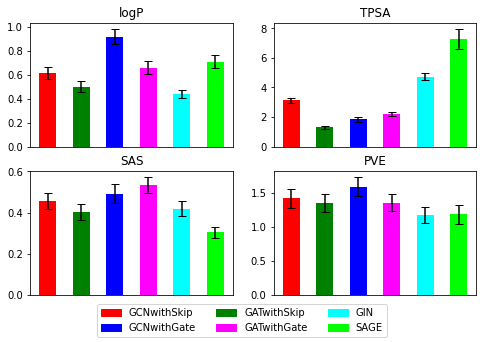

In [ ]:
title = 'One-hot feature training; MAE; Reproduce'
MAE_results = np.array([rearranged_results_GCNwithSkip[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithGate[:,0],rearranged_results_GIN[:,0],rearranged_results_SAGE[:,0]])
std = np.array([0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithGate[:,1],0.1*rearranged_results_GIN[:,1],0.1*rearranged_results_SAGE[:,1]])
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(MAE_results, std, models, tests,title)

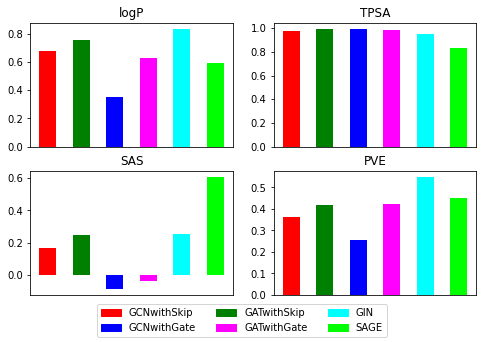

In [ ]:
title = 'One-hot feature training; R2; Reproduce'
R2_results = np.array([rearranged_results_GCNwithSkip[:,2],rearranged_results_GATwithSkip[:,2],rearranged_results_GCNwithGate[:,2],rearranged_results_GATwithGate[:,2],rearranged_results_GIN[:,2],rearranged_results_SAGE[:,2]])
std = None
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(R2_results, std, models, tests,title)

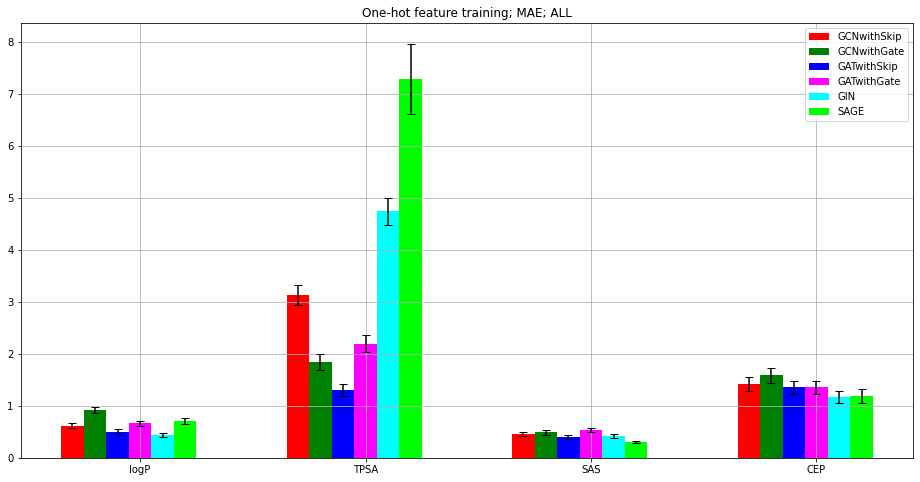

In [ ]:
title = 'One-hot feature training; MAE; ALL'
MAE_results = [rearranged_results_GCNwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GATwithGate[:,0], rearranged_results_GIN[:,0], rearranged_results_SAGE[:,0]]
std = [0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GATwithGate[:,1], 0.1*rearranged_results_GIN[:,1], 0.1*rearranged_results_SAGE[:,1]]
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(MAE_results, std, models, tests,title)

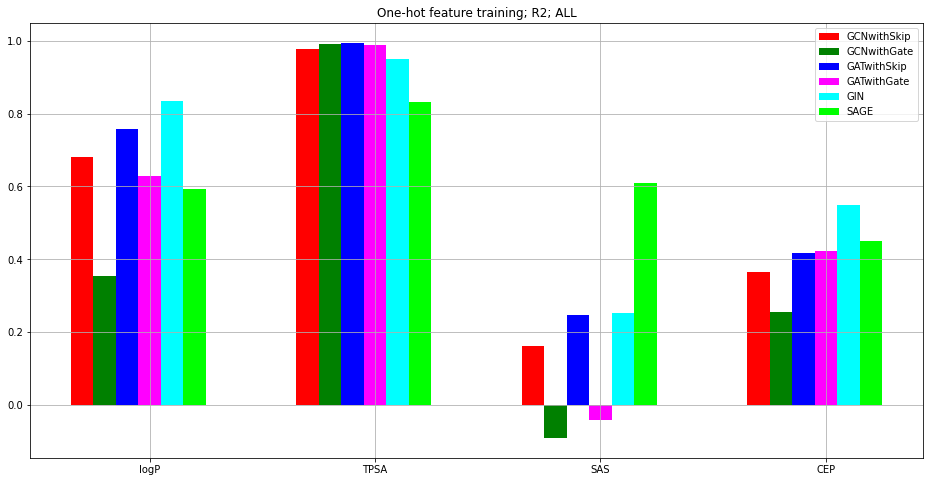

In [ ]:
title = 'One-hot feature training; R2; ALL'
R2_results = [rearranged_results_GCNwithSkip[:,2], rearranged_results_GCNwithGate[:,2], rearranged_results_GATwithSkip[:,2], rearranged_results_GATwithGate[:,2], rearranged_results_GIN[:,2], rearranged_results_SAGE[:,2]]
std = None
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(R2_results, std, models, tests, title)